# Test Interpolation Data

This notebook tests the interpolation functionality from the `interpolate_data.py` script.

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from tqdm import tqdm

## Setup Data Directories

In [2]:
# Define data directories
# base_data_dir = '/srv/scratch/z5370003/projects/data/groundwater/FEFLOW/coastal/variable_density/'
base_data_dir = '/Users/arpitkapoor/Library/CloudStorage/OneDrive-UNSW/Shared/Projects/01_PhD/05_groundwater/data/FEFLOW/variable_density'  # Uncomment for local testing
raw_data_dir = os.path.join(base_data_dir, 'all')
filtered_data_dir = os.path.join(base_data_dir, 'filter_all_ts')

print(f"Base data directory: {base_data_dir}")
print(f"Filtered data directory: {filtered_data_dir}")
print(f"Directory exists: {os.path.exists(filtered_data_dir)}")

Base data directory: /Users/arpitkapoor/Library/CloudStorage/OneDrive-UNSW/Shared/Projects/01_PhD/05_groundwater/data/FEFLOW/variable_density
Filtered data directory: /Users/arpitkapoor/Library/CloudStorage/OneDrive-UNSW/Shared/Projects/01_PhD/05_groundwater/data/FEFLOW/variable_density/filter_all_ts
Directory exists: True


## Get and Sort Time Series Files

In [3]:
# Get and sort time series files
ts_files = sorted(os.listdir(filtered_data_dir))
print(f"Total number of files: {len(ts_files)}")
print(f"First 3 files: {ts_files[:3]}")
print(f"Last 3 files: {ts_files[-3:]}")

Total number of files: 1909
First 3 files: ['0000.csv', '0001.csv', '0002.csv']
Last 3 files: ['1906.csv', '1907.csv', '1908.csv']


## Define Interpolation Function

In [4]:
def interpolate(X, Y, Z, values):
    """Interpolate 3D data onto a regular grid.
    
    Args:
        X, Y, Z: Input coordinates
        values: Values to interpolate
        
    Returns:
        tuple: (interpolated data, x_grid, y_grid, z_grid)
    """
    # Get min/max bounds for each dimension
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    z_min, z_max = Z.min(), Z.max()
    
    # Create regular 3D grid
    x_grid = np.linspace(x_min, x_max, 40)
    y_grid = np.linspace(y_min, y_max, 40)
    z_grid = np.linspace(z_min, z_max, 40)
    
    # Create meshgrid for interpolation points
    X_interp, Y_interp, Z_interp = np.meshgrid(x_grid, y_grid, z_grid)
    points = np.column_stack((X, Y, Z))
    
    # Interpolate values onto regular grid
    interpolated = griddata(
        points, 
        values,
        (X_interp, Y_interp, Z_interp),
        method='linear',
        fill_value=np.nan
    )
    
    return np.transpose(interpolated, (1, 0, 2)), x_grid, y_grid, z_grid

## Test Interpolation on a Single File

In [5]:
# Test interpolation on a single file first
test_file = ts_files[0]
print(f"Testing with file: {test_file}")

# Load data
res_df = pd.read_csv(os.path.join(filtered_data_dir, test_file))
print(f"Data shape: {res_df.shape}")
print(f"Columns: {res_df.columns.tolist()}")
print(f"Data range - X: [{res_df.X.min():.2f}, {res_df.X.max():.2f}]")
print(f"Data range - Y: [{res_df.Y.min():.2f}, {res_df.Y.max():.2f}]")
print(f"Data range - Z: [{res_df.Z.min():.2f}, {res_df.Z.max():.2f}]")
print(f"Head range: [{res_df['head'].min():.2f}, {res_df['head'].max():.2f}]")

Testing with file: 0000.csv
Data shape: (10227, 10)
Columns: ['node', 'ts', 'time (d)', 'X', 'Y', 'Z', 'slice', 'mass_concentration', 'pressure', 'head']
Data range - X: [355702.40, 358345.95]
Data range - Y: [6456013.44, 6459170.98]
Data range - Z: [-35.00, 33.87]
Head range: [0.01, 0.86]


In [6]:
# Perform interpolation
inter_res, x_grid, y_grid, z_grid = interpolate(
    res_df.X, res_df.Y, res_df.Z, res_df['head']
)

print(f"Interpolated data shape: {inter_res.shape}")
print(f"Grid shapes - X: {x_grid.shape}, Y: {y_grid.shape}, Z: {z_grid.shape}")
print(f"Interpolated data range: [{np.nanmin(inter_res):.2f}, {np.nanmax(inter_res):.2f}]")

Interpolated data shape: (40, 40, 40)
Grid shapes - X: (40,), Y: (40,), Z: (40,)
Interpolated data range: [0.03, 0.86]


## Process All Time Series Files

In [13]:
# Process all time series files
interpolated_data = []
for ts_file in tqdm(ts_files):
    res_df = pd.read_csv(os.path.join(filtered_data_dir, ts_file))
    origin = res_df[['X', 'Y', 'Z']].min().values
    
    inter_res, x_grid, y_grid, z_grid = interpolate(
        res_df.X, res_df.Y, res_df.Z, res_df['head']
    )
    interpolated_data.append(inter_res)

interpolated_data = np.array(interpolated_data)
print(f"Interpolated data shape: {interpolated_data.shape}")

  2%|▏         | 39/1909 [01:01<48:52,  1.57s/it]


KeyboardInterrupt: 

## Save Interpolated Data

In [11]:
# Create interpolated directory if it doesn't exist
interpolated_dir = os.path.join(base_data_dir, 'interpolated')
os.makedirs(interpolated_dir, exist_ok=True)

# Save interpolated data and grids
# np.save(os.path.join(interpolated_dir, 'data.npy'), interpolated_data)
# np.save(os.path.join(interpolated_dir, 'x_grid.npy'), x_grid)
# np.save(os.path.join(interpolated_dir, 'y_grid.npy'), y_grid)
# np.save(os.path.join(interpolated_dir, 'z_grid.npy'), z_grid)

print(f"Saved interpolated data and grids to {interpolated_dir}")

Saved interpolated data and grids to /Users/arpitkapoor/Library/CloudStorage/OneDrive-UNSW/Shared/Projects/01_PhD/05_groundwater/data/FEFLOW/variable_density/interpolated


## Visualization Functions

In [8]:
def plot_3d_slices(inter_res, x_grid, y_grid, z_grid):
    """Plot 3D slices of interpolated data."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    vmin, vmax = np.nanmin(inter_res), np.nanmax(inter_res)
    
    # YZ plane (constant X)
    for ix in range(inter_res.shape[0]):
        im1 = ax1.imshow(
            inter_res[ix,:,:].T,
            aspect='auto',
            extent=[y_grid[0], y_grid[-1], z_grid[0], z_grid[-1]],
            origin='lower',
            cmap='viridis',
            alpha=0.1,
            vmin=vmin,
            vmax=vmax
        )
    ax1.set_title('YZ plane (constant X)')
    ax1.set_xlabel('Y')
    ax1.set_ylabel('Z')
    plt.colorbar(im1, ax=ax1)
    
    # XZ plane (constant Y)
    for iy in range(inter_res.shape[1]):
        im2 = ax2.imshow(
            inter_res[:,iy,:].T,
            aspect='auto',
            extent=[x_grid[0], x_grid[-1], z_grid[0], z_grid[-1]],
            origin='lower',
            cmap='viridis',
            alpha=0.1,
            vmin=vmin,
            vmax=vmax
        )
    ax2.set_title('XZ plane (constant Y)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    plt.colorbar(im2, ax=ax2)
    
    # XY plane (constant Z)
    for iz in range(inter_res.shape[2]):
        im3 = ax3.imshow(
            inter_res[:,:,iz].T,
            aspect='auto',
            extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            origin='lower',
            cmap='viridis',
            alpha=0.1,
            vmin=vmin,
            vmax=vmax
        )
    ax3.set_title('XY plane (constant Z)')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_scatter_slices(res_df):
    """Plot scatter plots of raw data in 3D slices."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # YZ plane (constant X)
    ax1.scatter(res_df.Y, res_df.Z, c=res_df['head'], cmap='viridis', alpha=0.3)
    ax1.set_title('YZ plane (constant X)')
    plt.colorbar(ax1.collections[0], ax=ax1)
    
    # XZ plane (constant Y)
    ax2.scatter(res_df.X, res_df.Z, c=res_df['head'], cmap='viridis', alpha=0.3)
    ax2.set_title('XZ plane (constant Y)')
    plt.colorbar(ax2.collections[0], ax=ax2)
    
    # XY plane (constant Z)
    ax3.scatter(res_df.X, res_df.Y, c=res_df['head'], cmap='viridis', alpha=0.3)
    ax3.set_title('XY plane (constant Z)')
    plt.colorbar(ax3.collections[0], ax=ax3)
    
    plt.tight_layout()
    plt.show()

## Visualize Results

Plotting interpolated data slices...


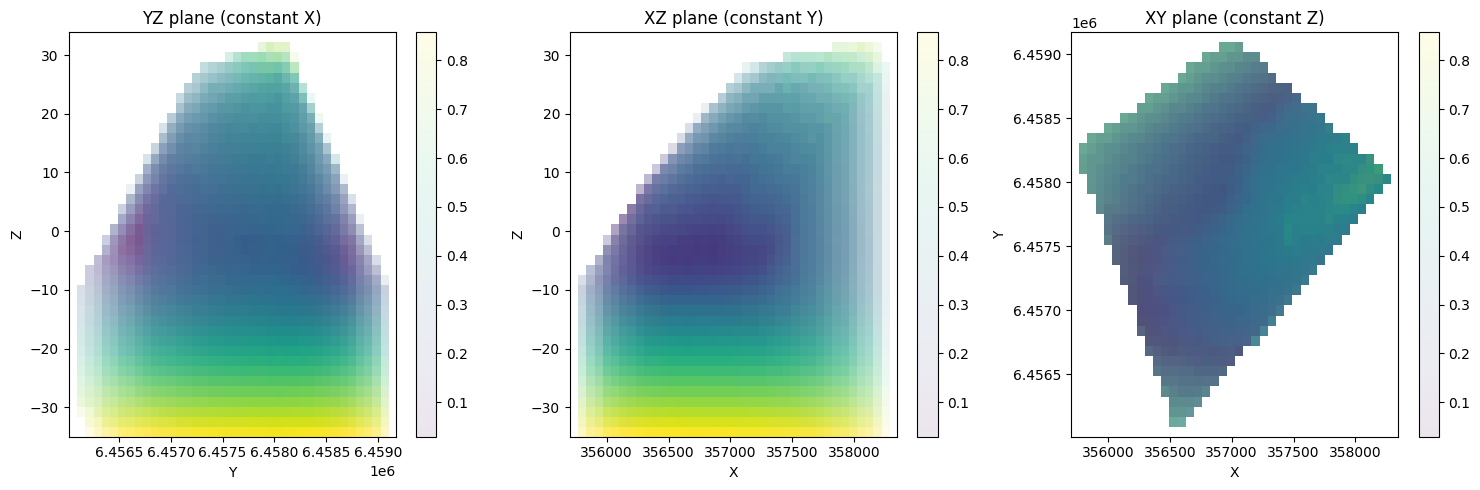

Plotting raw data scatter plots...


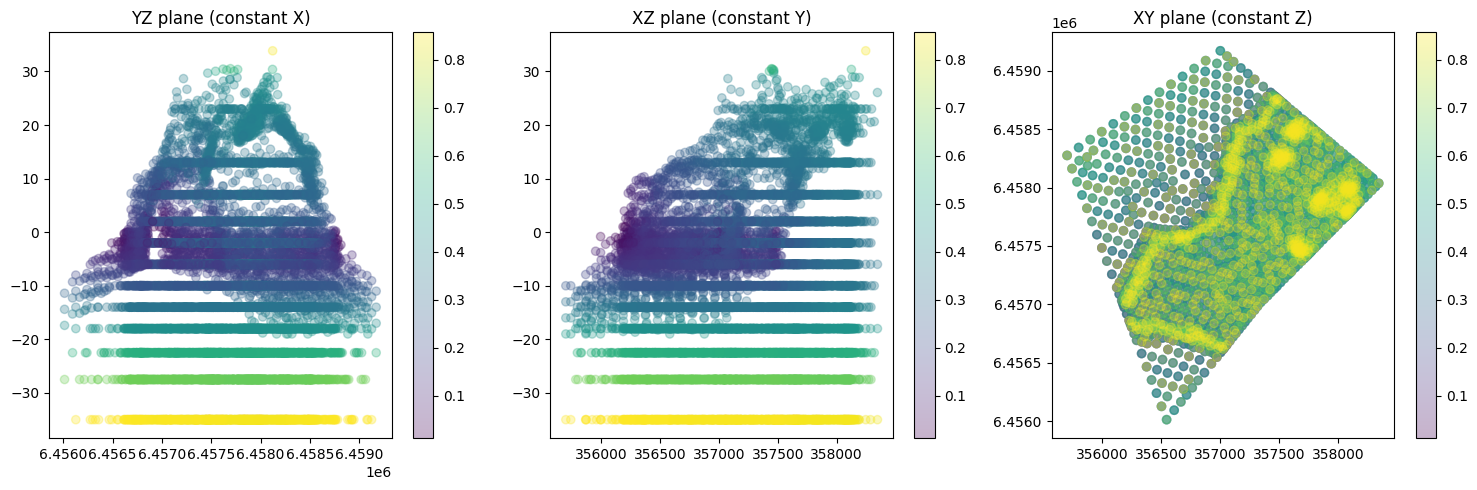

In [10]:
# Plot the results for the first file
print("Plotting interpolated data slices...")
plot_3d_slices(inter_res, x_grid, y_grid, z_grid)

print("Plotting raw data scatter plots...")
plot_scatter_slices(res_df)

## Load and Verify Saved Data

In [12]:
# Load saved data to verify
loaded_data = np.load(os.path.join(interpolated_dir, 'data.npy'))
loaded_x_grid = np.load(os.path.join(interpolated_dir, 'x_grid.npy'))
loaded_y_grid = np.load(os.path.join(interpolated_dir, 'y_grid.npy'))
loaded_z_grid = np.load(os.path.join(interpolated_dir, 'z_grid.npy'))

print(f"Loaded data shape: {loaded_data.shape}")
print(f"Loaded grid shapes - X: {loaded_x_grid.shape}, Y: {loaded_y_grid.shape}, Z: {loaded_z_grid.shape}")
print(f"Data verification - Arrays equal: {np.array_equal(interpolated_data, loaded_data)}")
print(f"Grid verification - X equal: {np.array_equal(x_grid, loaded_x_grid)}")
print(f"Grid verification - Y equal: {np.array_equal(y_grid, loaded_y_grid)}")
print(f"Grid verification - Z equal: {np.array_equal(z_grid, loaded_z_grid)}")

Loaded data shape: (1909, 40, 40, 40)
Loaded grid shapes - X: (40,), Y: (40,), Z: (40,)


NameError: name 'interpolated_data' is not defined

## Summary Statistics

In [ ]:
# Calculate summary statistics
print("=== Summary Statistics ===")
print(f"Total time steps: {loaded_data.shape[0]}")
print(f"Grid dimensions: {loaded_data.shape[1]} x {loaded_data.shape[2]} x {loaded_data.shape[3]}")
print(f"Total grid points: {loaded_data.shape[1] * loaded_data.shape[2] * loaded_data.shape[3]}")
print(f"Data range across all time steps: [{np.nanmin(loaded_data):.2f}, {np.nanmax(loaded_data):.2f}]")
print(f"Percentage of NaN values: {np.isnan(loaded_data).sum() / loaded_data.size * 100:.2f}%")

# Time series statistics
time_series_stats = {
    'mean': np.nanmean(loaded_data, axis=(1, 2, 3)),
    'std': np.nanstd(loaded_data, axis=(1, 2, 3)),
    'min': np.nanmin(loaded_data, axis=(1, 2, 3)),
    'max': np.nanmax(loaded_data, axis=(1, 2, 3))
}

print(f"\nTime series statistics:")
print(f"Mean range: [{time_series_stats['mean'].min():.2f}, {time_series_stats['mean'].max():.2f}]")
print(f"Std range: [{time_series_stats['std'].min():.2f}, {time_series_stats['std'].max():.2f}]")
print(f"Min range: [{time_series_stats['min'].min():.2f}, {time_series_stats['min'].max():.2f}]")
print(f"Max range: [{time_series_stats['max'].min():.2f}, {time_series_stats['max'].max():.2f}]")